# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 2: сверточный классификатор.

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит познакомиться со сверточными сетями и их обучением для классификации изображений с использованием библиотеки PyTorch.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

## 0. Загрузка данных

Работать мы будем с набором данных [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html). CIFAR10 представляет собой набор изображений 32х32 пикселя, разделенных на 10 классов.

![title](https://pytorch.org/tutorials/_images/cifar10.png)




Набор данных уже определен в <code>torchvision.datasets</code>, так что возьмем его оттуда. 



In [3]:
def get_cifar10_data(batch_size, transform_train):
    torch.manual_seed(0)
    np.random.seed(0)

    transform_test = transforms.Compose(
        [transforms.ToTensor(),
         # Переводим цвета пикселей в отрезок [-1, 1]
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    
    # Загружаем данные
    trainvalset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                               download=True, transform=transform_train)
    testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    
    # В датасете определено разбиение только на train и test,
    # так что валидацию дополнительно выделяем из обучающей выборки
    train_idx, valid_idx = train_test_split(np.arange(len(trainvalset)), test_size=0.3, 
                                            shuffle=True, random_state=0)
    trainset = torch.utils.data.Subset(trainvalset, train_idx)
    valset = torch.utils.data.Subset(trainvalset, valid_idx)

    train_loader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                               shuffle=True, num_workers=2)
    val_loader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                             shuffle=False, num_workers=2)
    test_loader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                              shuffle=False, num_workers=2)
    
    return train_loader, val_loader, test_loader
    

In [4]:
transform = transforms.Compose(
        [transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, 
                                                         transform_train=transform)

Files already downloaded and verified
Files already downloaded and verified


Посмотрим на изображения:

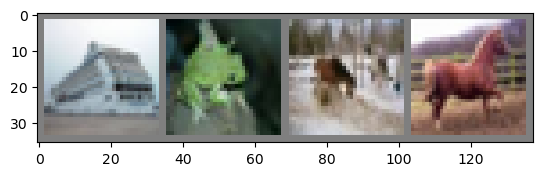

ship frog horse horse


In [5]:
def imshow(img):
    img = img / 2 + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
print(*[classes[labels[i]] for i in range(4)])

## 1. Задание сверточной сети (3 балла)

Теперь нам нужно задать сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Используем сеть, основанную на одном блоке архитектуры ResNet.

<img src="https://i.ibb.co/2hg962h/basic-block.png" width="500"/>

__Указания:__

- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Выход блока сократите до размерности 32х4х4, применив average pooling.
- Для получения итоговых логитов, распрямите выход пулинга в вектор из 512 элементов, а затем пропустите его через линейный слой.

**Задание 1.1 (3 балла).**

Определите архитектуру сети соответственно схеме и указаниям выше.

Ключевые слова: <code>Conv2d</code>, <code>BatchNorm2d</code>, <code>AvgPool2d</code>.

In [6]:
n_classes = 10

class BasicBlockNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding='same'),
            nn.BatchNorm2d(num_features=32),
        )

        self.skip_connenction = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=1, padding='same')
        self.pooling = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8)
        )
        self.linear = nn.Linear(in_features=512, out_features=n_classes)

    def forward(self, x):
        out = self.encoder(x) + self.skip_connenction(x)
        out = self.pooling(out)
        out = self.linear(out.reshape((-1, 512)))

        return out

In [7]:
net = BasicBlockNet()
net

BasicBlockNet(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (skip_connenction): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), padding=same)
  (pooling): Sequential(
    (0): ReLU()
    (1): AvgPool2d(kernel_size=8, stride=8, padding=0)
  )
  (linear): Linear(in_features=512, out_features=10, bias=True)
)

Проверим, что выход сети имеет корректную размерность:

In [8]:
assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

Чтобы проводить вычисления на GPU, в PyTorch необходимо руками перекладывать объекты, с которыми вы хотите проводить вычисления, на графический ускоритель. Это делается следующим образрм:

In [9]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [10]:
net = net.to(device)

Подключение GPU в google.colab:

**Среда выполнения** -> **Сменить среду выполнения** -> **Аппаратный ускоритель** -> **GPU**

## 2. Обучение и тестирование модели (3 балла)

**Задание 2.1 (2 балла).** Переходим к обучению модели. Заполните пропуски в функциях <code>test</code> и <code>train_epoch</code>. В качестве функции потерь будем использовать [кросс-энтропию](https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html), а в качестве метрики качества accuracy.

In [11]:
def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()

    criterion = nn.CrossEntropyLoss()
    
    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        with torch.no_grad():
          logits = model(data)
          loss = criterion(logits, target)

        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        
        loss_log.append(loss.item())
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()

    criterion = nn.CrossEntropyLoss()
    
    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        
        loss_log.append(loss.item())
        acc_log.append(acc.item()) 

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

Запустим обучение модели. В качестве оптимизатора будем использовать стохастический градиентный спуск, который является де-факто стандартом в задачах компьютерного зрения (наравне с <code>Adam</code>).

__Замечание:__ Для достижения наилучшего качества в нашем случае потребуется обучать модель несколько сотен эпох. Однако в целях экономии вашего времени и сил, во всех экспериментах мы ограничимся 20 эпохами.

In [13]:
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.458876866091322, train acc: 0.4826284604491002
 val loss: 1.2073494852857387, val acc: 0.5720079787234043

Epoch 1
 train loss: 1.1447644219537976, train acc: 0.5991610081583751
 val loss: 1.096054131173073, val acc: 0.6232491135597229

Epoch 2
 train loss: 1.0410441394479881, train acc: 0.6389437517256797
 val loss: 1.0629014296734587, val acc: 0.6323803191489362

Epoch 3
 train loss: 0.9877199135053311, train acc: 0.6577843432016739
 val loss: 1.1032871264092465, val acc: 0.6212322696726373

Epoch 4
 train loss: 0.9512273574442053, train acc: 0.6677167668421046
 val loss: 1.008125992531472, val acc: 0.6502437944107867

Epoch 5
 train loss: 0.9273118849646239, train acc: 0.675890408769604
 val loss: 0.9704403276139117, val acc: 0.670035461161999

Epoch 6
 train loss: 0.899570203459459, train acc: 0.6863206777537763
 val loss: 1.058451500091147, val acc: 0.6447695037151905

Epoch 7
 train loss: 0.882464779414904, train acc: 0.6921519979262483
 val loss: 0.9378227

Посчитайте точность на тестовой выборке:

In [14]:
test_loss, test_acc = test(net, test_loader)

In [15]:
test_loss, test_acc

(0.8753219846707241, 0.6983479299363057)

Если вы все сделали правильно, у вас должна была получиться точность $\ge 67\%$.

**Задание 2.2 (1 балл).** Постройте графики зависимости функции потерь и точности классификации от номера шага оптимизатора. На каждом графике расположите данные и для обучающей и для валидационной выборки, итого у вас должно получиться два графика. Обратите внимание, что на обучающей выборке эти данные считаются по каждому батчу, на валидационной же они считаются по всей выборке раз в эпоху.

In [16]:
def plot_losses(train_losses, train_accs, val_losses, val_accs):
    fig, axs = plt.subplots(1, 2, figsize=(20, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[0].set_ylabel('loss')

    axs[1].plot(range(1, len(train_accs) + 1), train_accs, label='train')
    axs[1].plot(range(1, len(val_accs) + 1), val_accs, label='val')
    axs[1].set_ylabel('accuracy')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    plt.show()

In [17]:
epoch_num = 20
epoch_size = int(np.ceil(len(train_loss_log) / 64))
train_losses, train_accs = [], []

for i in range(epoch_num):
  loss_interval = train_loss_log[i * epoch_size: (i + 1) * epoch_size]
  acc_interval = train_acc_log[i * epoch_size: (i + 1) * epoch_size]
  train_losses.append(sum(loss_interval) / len(loss_interval))
  train_accs.append(sum(acc_interval) / len(acc_interval))

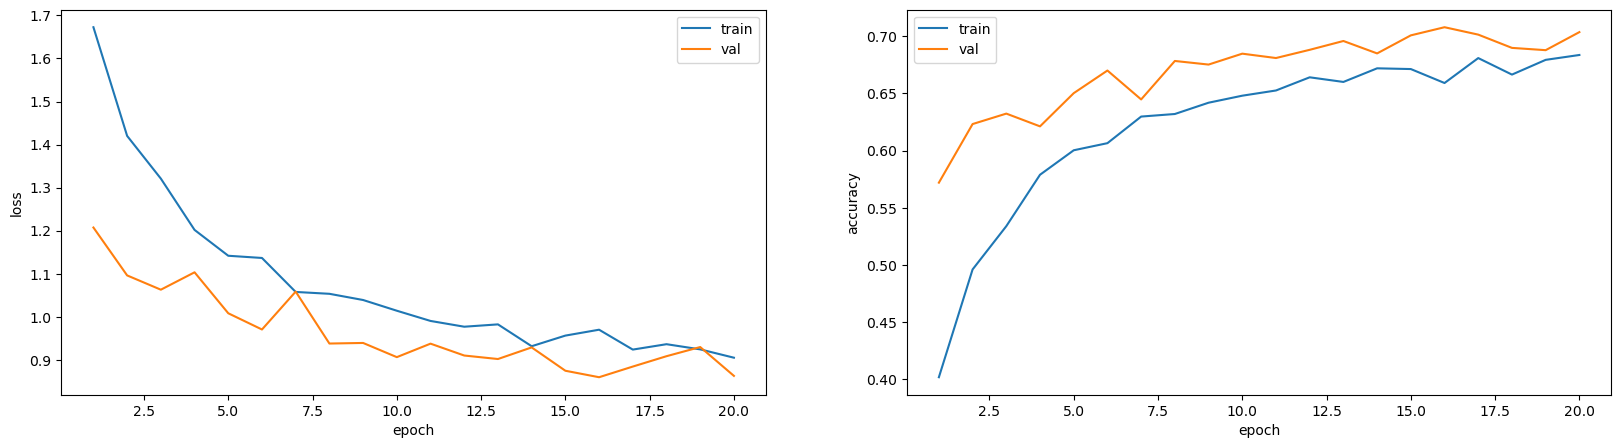

In [18]:
plot_losses(train_losses, train_accs, val_loss_log, val_acc_log)

## 3. Расписание длины шага (2 балла)

С курса "Машинное обучение 1" вы уже должны знать, что сходимость стохастического градиентного спуска мы можем теоретически гарантировать только если будем определенным образом со временем уменьшать длину шага. На практике при обучении нейронных сетей такая техника оказывается очень полезной, однако теоретически обоснованными способами уменьшения длины шага фантазия не ограничивается.

Одним из простейших способов является кусочно постоянная функция: на нескольких фиксированных эпохах уменьшаем длину шага в константу раз.

In [19]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.470600215564916, train acc: 0.47530768482079233
 val loss: 1.325147253401736, val acc: 0.5338874114320633

Epoch 1
 train loss: 1.154785999323376, train acc: 0.5933215265082267
 val loss: 1.1057226358576024, val acc: 0.617597517815042

Epoch 2
 train loss: 1.0515478853769669, train acc: 0.6334021612320783
 val loss: 1.1915129626050909, val acc: 0.5873670212765958

Epoch 3
 train loss: 0.9907442831470064, train acc: 0.6541198747031649
 val loss: 1.0284191375083112, val acc: 0.6490026595744681

Epoch 4
 train loss: 0.9526587304075196, train acc: 0.6670271285709123
 val loss: 1.0043473352777197, val acc: 0.6475842199427017

Epoch 5
 train loss: 0.9180450638316885, train acc: 0.6800241578213694
 val loss: 0.9695457681696465, val acc: 0.6642952127659575

Epoch 6
 train loss: 0.9009483888118751, train acc: 0.6847251240688442
 val loss: 0.9239315509796142, val acc: 0.678036347602276

Epoch 7
 train loss: 0.8843506466753958, train acc: 0.6908829002973148
 val loss: 0.908

Посчитайте точность на тестовой выборке:

In [20]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8270988147349874, 0.7136743630573248)

**Задание 3.0 (0.5 баллов).** Здесь может возникнуть вопрос: а что будет, если мы не будем уменьшать длину шага в процессе обучения, а сразу возьмем констатную, равную значению нашей кусочно-постоянной функции на последних эпохах, то есть $0.001$ в нашем случае. Запустите обучение и проверьте, что в таком случае мы получим худшее качество на тестовой выборке.

In [21]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.8587566352631535, train acc: 0.34674931444241314
 val loss: 1.638531595088066, val acc: 0.4319148936170213

Epoch 1
 train loss: 1.572601719573821, train acc: 0.44766502352039816
 val loss: 1.4883751118436772, val acc: 0.47781471635432954

Epoch 2
 train loss: 1.4449474151217305, train acc: 0.4921242492290476
 val loss: 1.4078914424206348, val acc: 0.5047650710065315

Epoch 3
 train loss: 1.3606903204316414, train acc: 0.5224316075471463
 val loss: 1.3137816353047147, val acc: 0.541001773134191

Epoch 4
 train loss: 1.2995640509089343, train acc: 0.5455120463040019
 val loss: 1.2575758530738506, val acc: 0.5643173759287976

Epoch 5
 train loss: 1.2456988387177588, train acc: 0.5638751959669961
 val loss: 1.2152707556460767, val acc: 0.5783687944107867

Epoch 6
 train loss: 1.2047151152786868, train acc: 0.5816425634258626
 val loss: 1.2025074309491097, val acc: 0.5808953901554675

Epoch 7
 train loss: 1.1603305895542095, train acc: 0.5961004832327039
 val loss: 1

In [22]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.9371898743757017, 0.675656847133758)

Качество действительно ухудшилось

**Задание 3.1 (1.5 балла).** Изучите, какие еще способы уменьшения длины шага представлены в <code>torch.optim.lr_scheduler</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними. Удалось ли добиться улучшения качества на тестовой выборке?

In [24]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.4705381345487383, train acc: 0.47466701497979313
 val loss: 1.2869817868192146, val acc: 0.5531028369639782

Epoch 1
 train loss: 1.0975985841951597, train acc: 0.6166508879914362
 val loss: 1.0814169777200577, val acc: 0.6216755319148937

Epoch 2
 train loss: 1.0383388285663053, train acc: 0.6390743340609061
 val loss: 1.0527869919513135, val acc: 0.6324024824385948

Epoch 3
 train loss: 1.0317836857147147, train acc: 0.640620919315645
 val loss: 1.051238541400179, val acc: 0.6324024824385948

Epoch 4
 train loss: 1.0293208564439247, train acc: 0.6420450836038677
 val loss: 1.0515626235211148, val acc: 0.6326019505237012

Epoch 5
 train loss: 1.0292182370775143, train acc: 0.641131006821418
 val loss: 1.0513254936705245, val acc: 0.6331338654173181

Epoch 6
 train loss: 1.0307799276965628, train acc: 0.6410861191845463
 val loss: 1.051683603195434, val acc: 0.6336657803109351

Epoch 7
 train loss: 1.0310985831717467, train acc: 0.6424164272967379
 val loss: 1.05

In [25]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(1.05771852982272, 0.6275875796178344)

**При использовании ExponentialLR качество ухудшилось**

In [12]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=0.001, max_lr=0.1, step_size_up=5, mode="triangular2")
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Epoch 0
 train loss: 1.8165423878803986, train acc: 0.3659204427677273
 val loss: 1.6033872771770397, val acc: 0.4425310284533399

Epoch 1
 train loss: 1.4101368826311729, train acc: 0.49303832601149733
 val loss: 1.2539129546348085, val acc: 0.5517952127659574

Epoch 2
 train loss: 1.1777724718480922, train acc: 0.584499053371018
 val loss: 1.0929728495313766, val acc: 0.6189494680851064

Epoch 3
 train loss: 1.065080722681565, train acc: 0.6307986745886655
 val loss: 1.1318722430695878, val acc: 0.5925531914893617

Epoch 4
 train loss: 1.0051001210099382, train acc: 0.6497167995032707
 val loss: 1.0068428108032714, val acc: 0.6482269505237012

Epoch 5
 train loss: 0.9639770358092606, train acc: 0.6640400561815641
 val loss: 0.9910683182959861, val acc: 0.652814716481148

Epoch 6
 train loss: 0.9118165882675477, train acc: 0.6861778532565185
 val loss: 1.0499877901787453, val acc: 0.6379432624958931

Epoch 7
 train loss: 0.8746497183220914, train acc: 0.6990565422248143
 val loss: 0.8

In [13]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.7916328593803819, 0.7291003184713376)

**При использовании CyclicLR качество удалось немного улучшить**

1. ExponentialLR на каждом шаге умножает lr на gamma (доллжна быть <1), которая задается в виде параметра. $$lr_{epoch} = lr_{init} \cdot gamma^{epoch}$$
2. CyclicLR - triangular2 принимает параметры base_lr (нижняя граница цикла) и max_lr (верхняя граница цикла) и затем циклически изменяет lr в этих границах соответственно параметрам step_size_up (задает количество итераций обучения когда lr увеличивается перед достижением верхней max_lr) и step_size_down (то же самое, но кол-во итераций при уменьшении lr от max_lr к base_lr). Поддерживает разные форматы работы, я использовал triangular2, который после каждого цикла (base_lr->max_lr->base_lr) в два раза уменьшает растояние от base_lr к max_lr, опуская границу max_lr. Таким образом, это позволяет избежать попадания в локальный минимум и при этом дает возможность модели достаточно быстро обучаться по началу.

## 4. Аугментации данных (2 балла)

Еще одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки, тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.

Простейшая аугментация, которую можно применить к картинкам — разворот картинки по горизонтальной оси. То есть при обучении модели с вероятностью $0.5$ мы будем разворачивать картинку из обучающей выборки.

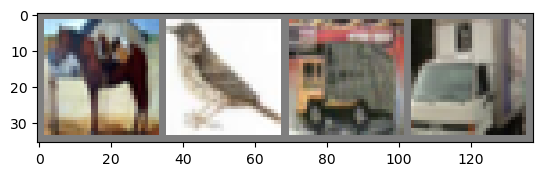

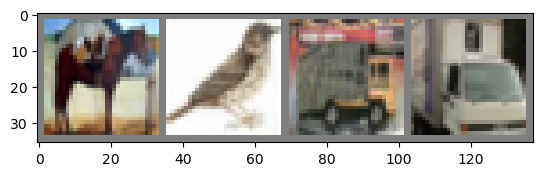

In [14]:
dataiter = iter(train_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images[:4]))

imshow(torchvision.utils.make_grid(transforms.functional.hflip(images[:4])))

Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке <code>transforms</code>, который затем передается в загрузчик данных. Обучим нашу сеть, применяя горизонтальные повороты:

In [15]:
transform = transforms.Compose(
        [transforms.RandomHorizontalFlip(),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4867492094772172, train acc: 0.4704149256458666
 val loss: 1.2877302636491492, val acc: 0.5401595744680852

Epoch 1
 train loss: 1.1874222009011988, train acc: 0.5812263319871543
 val loss: 1.1225111050808683, val acc: 0.6056737590343394

Epoch 2
 train loss: 1.058859269950246, train acc: 0.6290113280852491
 val loss: 1.0659550512090643, val acc: 0.6293439718002969

Epoch 3
 train loss: 0.998001136335202, train acc: 0.6527201946300388
 val loss: 1.0010883199407699, val acc: 0.6546099292471054

Epoch 4
 train loss: 0.9600663453177081, train acc: 0.6678106229091693
 val loss: 0.9841058629624387, val acc: 0.6573581561129144

Epoch 5
 train loss: 0.9236572344516706, train acc: 0.6789835792790819
 val loss: 0.9459199479285707, val acc: 0.6679742908224147

Epoch 6
 train loss: 0.9070864776370731, train acc: 0.6879733612376113
 val loss: 0.9557873933873278, val acc: 0.6671320922831272

Epoch 7
 

Посчитайте точность на тестовой выборке:

In [16]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.7984436129688457, 0.732484076433121)

**Задание 4.1 (2 балла).** Изучите, какие еще способы аугментаций изображений представлены в <code>torchvision.transforms</code>. Выберите несколько из них, объясните, как они устроены, и обучите модель с ними (по отдельности и вместе). Удалось ли добиться улучшения качества на тестовой выборке?

In [19]:
transform = transforms.Compose(
        [transforms.RandomPerspective(distortion_scale=0.4, p=0.7),
         transforms.ColorJitter(0.1, 0.1, 0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.6746466665424855, train acc: 0.3981538914021452
 val loss: 1.4822775049412504, val acc: 0.46099290784369124

Epoch 1
 train loss: 1.4134264151400577, train acc: 0.494160518458818
 val loss: 1.3157039931479921, val acc: 0.5407801420130628

Epoch 2
 train loss: 1.2951373309714267, train acc: 0.5395787085867887
 val loss: 1.2625694640139316, val acc: 0.5554742908224146

Epoch 3
 train loss: 1.223482102537068, train acc: 0.5689801514911478
 val loss: 1.1812563350860108, val acc: 0.584219858240574

Epoch 4
 train loss: 1.1769334429796696, train acc: 0.58528662839363
 val loss: 1.2906886646088134, val acc: 0.5560948582405739

Epoch 5
 train loss: 1.145904145249501, train acc: 0.5980877840322811
 val loss: 1.1591081936308678, val acc: 0.5924645390916378

Epoch 6
 train loss: 1.114597914314793, train acc: 0.6079467550274223
 val loss: 1.0960657883197704, val acc: 0.613031914893617

Epoch 7
 train

In [20]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8881213177161612, 0.6921775477707006)

**Качество ухудшилось**

In [21]:
transform = transforms.Compose(
        [transforms.RandomPerspective(distortion_scale=0.4, p=0.7),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4854159784491363, train acc: 0.4724063071297989
 val loss: 1.302109262537449, val acc: 0.5341976950777337

Epoch 1
 train loss: 1.1788007119020116, train acc: 0.5885919953613002
 val loss: 1.1087181235881562, val acc: 0.616046099333053

Epoch 2
 train loss: 1.0546959457711285, train acc: 0.6320351267427587
 val loss: 1.0519856802960659, val acc: 0.6356826241980208

Epoch 3
 train loss: 0.9861504049798034, train acc: 0.6562704035307415
 val loss: 0.9901363882612675, val acc: 0.6587987590343394

Epoch 4
 train loss: 0.9487785188110045, train acc: 0.6697244711724234
 val loss: 0.9921691651039936, val acc: 0.6523714539852549

Epoch 5
 train loss: 0.9199327064824496, train acc: 0.6797466701955638
 val loss: 0.9933998714102076, val acc: 0.6522828014607125

Epoch 6
 train loss: 0.8957880473877874, train acc: 0.6872510773826125
 val loss: 0.9244234381838048, val acc: 0.6784352837724889

Epoch 7
 

In [22]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8223985220975937, 0.7202428343949044)

**Качество стало чуть хуже, чем при использовании RandomHorizontalFlip, но выше чем когда использовался и RandomPerspective и ColorJitter**

In [25]:
transform = transforms.Compose(
        [transforms.ColorJitter(0.1, 0.1, 0.1),
         transforms.ToTensor(),
         transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

train_loader, val_loader, test_loader = get_cifar10_data(batch_size=64, transform_train=transform)

net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 15], gamma=0.1)
tr_loss_log, tr_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader, scheduler)

Files already downloaded and verified
Files already downloaded and verified
Epoch 0
 train loss: 1.4831260659576988, train acc: 0.4721859494118629
 val loss: 1.2754939895995119, val acc: 0.5419104610351806

Epoch 1
 train loss: 1.164827943175105, train acc: 0.5917790219378428
 val loss: 1.1188345630118188, val acc: 0.6096631206096487

Epoch 2
 train loss: 1.048505288700299, train acc: 0.6350058762857204
 val loss: 1.0326870695073553, val acc: 0.6444813829787234

Epoch 3
 train loss: 0.9842458868593359, train acc: 0.6564091473436443
 val loss: 1.0187545149884325, val acc: 0.6488696808510638

Epoch 4
 train loss: 0.9504792696815086, train acc: 0.6691694960297788
 val loss: 0.9951346856482486, val acc: 0.6523714539852549

Epoch 5
 train loss: 0.9199662495138876, train acc: 0.6793100353350805
 val loss: 0.9737514237140087, val acc: 0.6627437944107867

Epoch 6
 train loss: 0.8948519519194824, train acc: 0.6903034409395737
 val loss: 0.9324400787657879, val acc: 0.6751994680851063

Epoch 7
 

In [26]:
test_loss, test_acc = test(net, test_loader)
test_loss, test_acc

(0.8216555486818787, 0.7190485668789809)

**Качество ухудшилось чуть сильнее, чем при использовании только Random Perspective**

1. RandomPerspective. С заданной вероятностью выполняет случайное преобразование перспективы изображения.
2. ColorJitter. Произвольно изменяет яркость, контрастность, насыщенность и оттенки цветов изображения.

## Бонус. Логирование в wandb (2 балла)

На практике специалиста по глубинному обучению часто встречаются ситуации, когда нейросеть учится на каком-то удаленном сервере. И обычно вам хочется отслеживать прогресс обучения, особенно когда время обучения модели исчисляется днями или неделями. Для таких целей существует несколько инструментов. Вероятно, самый популярный из них — [wandb](https://wandb.ai/site).

Ваша задача состоит в том, чтобы разобраться как им пользоваться, и повторить задания 2.1 и 2.2 с его использованием. Обучение вы можете запускать в этом же ноутбуке, но теперь вам необходимо через wandb логировать значения функции потерь и точности на обучающей выборке и на валидационной. Результатом работы должны быть ваш код и публичная ссылка на страничку с графиками, идентичными графикам в задании 2.2.

In [35]:
import wandb

def test(model, loader):
    loss_log = []
    acc_log = []
    model.eval()
    
    criterion = nn.CrossEntropyLoss()

    for data, target in loader:
        data = data.to(device)
        target = target.to(device)

        logits = model(data)
        loss = criterion(logits, target)

        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        
        loss_log.append(loss.item())
        acc_log.append(acc.item()) 
        
    return np.mean(loss_log), np.mean(acc_log)

def train_epoch(model, optimizer, train_loader):
    loss_log = []
    acc_log = []
    model.train()
    
    criterion = nn.CrossEntropyLoss()

    for data, target in train_loader:
        data = data.to(device)
        target = target.to(device)

        optimizer.zero_grad()
        logits = model(data)
        loss = criterion(logits, target)
        loss.backward()
        optimizer.step()

        acc = (logits.argmax(dim=1) == target).sum() / data.shape[0]
        
        loss_log.append(loss.item())
        acc_log.append(acc.item())

    return loss_log, acc_log

def train(model, optimizer, n_epochs, train_loader, val_loader, scheduler=None):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_loss_epochs, train_acc_epochs = [], []
    run = wandb.init(project='shw2-dl')

    for epoch in range(n_epochs):
        train_loss, train_acc = train_epoch(model, optimizer, train_loader)
        val_loss, val_acc = test(model, val_loader)
        
        train_loss_log.extend(train_loss)
        train_acc_log.extend(train_acc)
        train_loss_epochs.append(np.mean(train_loss))
        train_acc_epochs.append(np.mean(train_acc))
        
        val_loss_log.append(val_loss)
        val_acc_log.append(val_acc)

        wandb.log({"Accuracy": wandb.plot.line_series(
                xs=list(range(epoch + 1)),
                ys=[train_acc_epochs, val_acc_log],
                keys=["train", "val"],
                title="Accuracy",
                xname="epoch")})
        
        wandb.log({"Loss": wandb.plot.line_series(
                xs=list(range(epoch + 1)),
                ys=[train_loss_epochs, val_loss_log],
                keys=["train", "val"],
                title="Loss",
                xname="epoch")})

        print(f"Epoch {epoch}")
        print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
        print(f" val loss: {val_loss}, val acc: {val_acc}\n")
        
        if scheduler is not None:
            scheduler.step()

    run.finish()

    return train_loss_log, train_acc_log, val_loss_log, val_acc_log

In [ ]:
net = BasicBlockNet().to(device)
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
train_loss_log, train_acc_log, val_loss_log, val_acc_log = train(net, optimizer, 20, train_loader, val_loader)

Epoch 0
 train loss: 1.4918937052189758, train acc: 0.4694926873857404
 val loss: 1.2084329574666124, val acc: 0.5741356382978723

Epoch 1
 train loss: 1.180236438074757, train acc: 0.5848132672649851
 val loss: 1.1252459465189184, val acc: 0.6140735816448293

Epoch 2
 train loss: 1.0649595903522135, train acc: 0.6280074759200897
 val loss: 1.0362725415128342, val acc: 0.6374335106382979

Epoch 3
 train loss: 1.0112733018245732, train acc: 0.6473091864716636
 val loss: 1.0428351105527676, val acc: 0.6352615249917862

Epoch 4
 train loss: 0.9699526940228952, train acc: 0.660506170127248
 val loss: 0.9710200228589646, val acc: 0.6574689718002968

Epoch 5
 train loss: 0.9439297070015065, train acc: 0.6705242883570669
 val loss: 0.9743613108675531, val acc: 0.6623005319148936

Epoch 6
 train loss: 0.9152223489620132, train acc: 0.682219574394784
 val loss: 0.9563361809608785, val acc: 0.6673980497299357

Epoch 7
 train loss: 0.8961902156172549, train acc: 0.688871115282641
 val loss: 0.922

Тут можно посмотреть графики: https://wandb.ai/yaraksen/shw2-dl/runs/1whlfswy